In [26]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as albu

import time
import os
from tqdm.notebook import tqdm

from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [28]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [29]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [30]:
print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))
print('the number of image/label in the test: ',len(os.listdir(x_test_dir)))

the number of image/label in the train:  367
the number of image/label in the validation:  101
the number of image/label in the test:  233


In [31]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [32]:
#画像およびマスクの表示用関数

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


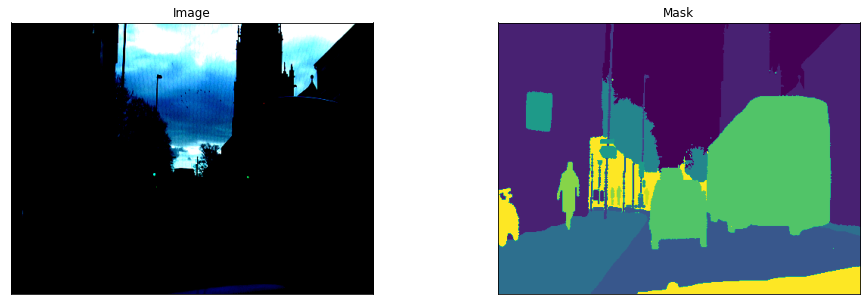

In [36]:
# Datasetの画像とマスクの確認。

dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'pedestrian'])

image, mask = dataset[5] # get some sample
visualize(
    image=image.permute(1, 2, 0), #To tensorでchannel, h, wが画像表示用と異なるため、配列変換
    mask=mask
)

In [37]:
def get_training_augmentation():
    train_transform = [


        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480),
        
    ]
    return albu.Compose(test_transform)

def test_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    #test_transform = [
    #   albu.PadIfNeeded(384, 480)
    #]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


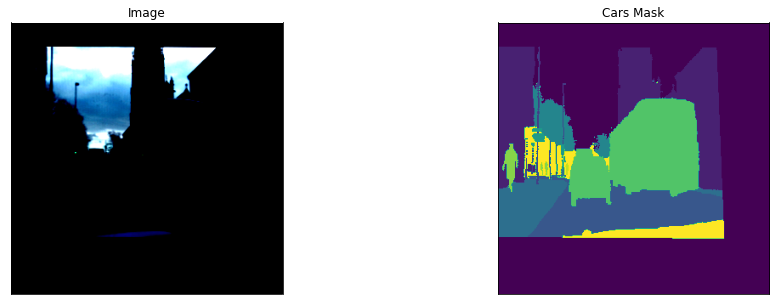

In [38]:
# Augumentation処理後の画像の確認

dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'pedestrian'], augmentation=get_training_augmentation())

image, mask = dataset[5] # get some sample
visualize(
    image=image.permute(1, 2, 0), 
    cars_mask=mask
)

In [39]:
#画像サイズの確認

image.shape

torch.Size([3, 320, 320])

In [40]:
#画像のクラスを設定

CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car', 'pedestrian', 'bicyclist', 'unlabelled']

In [41]:
#Semantic Segmentationのモデルを設定

model = smp.Unet('efficientnet-b4', encoder_weights='imagenet', classes=len(CLASSES), activation=None)

In [47]:
#Train, Validationのデータセットを作成

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [48]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [49]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=len(CLASSES)):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [50]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    #torch.save(model, 'Unet-_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader))) #Train途中もモデルを保存するときは実行する
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 20:
                    print('Loss not decrease for 20 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [51]:
max_lr = 1e-3
epoch = 100
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, valid_loader, criterion, optimizer, sched)


Loss Decreasing.. inf >> 2.399 
Epoch:1/100.. Train Loss: 2.609.. Val Loss: 2.399.. Train mIoU:0.037.. Val mIoU: 0.066.. Train Acc:0.114.. Val Acc:0.272.. Time: 0.46m



Loss Decreasing.. 2.399 >> 2.151 
Epoch:2/100.. Train Loss: 2.302.. Val Loss: 2.151.. Train mIoU:0.077.. Val mIoU: 0.082.. Train Acc:0.264.. Val Acc:0.333.. Time: 0.38m



Loss Decreasing.. 2.151 >> 1.852 
Epoch:3/100.. Train Loss: 1.982.. Val Loss: 1.852.. Train mIoU:0.126.. Val mIoU: 0.146.. Train Acc:0.436.. Val Acc:0.468.. Time: 0.39m



Loss Decreasing.. 1.852 >> 1.557 
saving model...
Epoch:4/100.. Train Loss: 1.663.. Val Loss: 1.557.. Train mIoU:0.164.. Val mIoU: 0.181.. Train Acc:0.590.. Val Acc:0.613.. Time: 0.39m



Loss Decreasing.. 1.557 >> 1.452 
Epoch:5/100.. Train Loss: 1.405.. Val Loss: 1.452.. Train mIoU:0.187.. Val mIoU: 0.188.. Train Acc:0.673.. Val Acc:0.625.. Time: 0.40m



Loss Decreasing.. 1.452 >> 1.290 
Epoch:6/100.. Train Loss: 1.194.. Val Loss: 1.290.. Train mIoU:0.209.. Val mIoU: 0.238.. Train Acc:0.709.. Val Acc:0.702.. Time: 0.40m



Loss Decreasing.. 1.290 >> 1.061 
Epoch:7/100.. Train Loss: 1.002.. Val Loss: 1.061.. Train mIoU:0.266.. Val mIoU: 0.277.. Train Acc:0.778.. Val Acc:0.764.. Time: 0.39m



Loss Decreasing.. 1.061 >> 0.849 
Epoch:8/100.. Train Loss: 0.835.. Val Loss: 0.849.. Train mIoU:0.291.. Val mIoU: 0.293.. Train Acc:0.816.. Val Acc:0.783.. Time: 0.39m



Loss Decreasing.. 0.849 >> 0.748 
saving model...
Epoch:9/100.. Train Loss: 0.679.. Val Loss: 0.748.. Train mIoU:0.306.. Val mIoU: 0.291.. Train Acc:0.841.. Val Acc:0.790.. Time: 0.39m



Loss Decreasing.. 0.748 >> 0.700 
Epoch:10/100.. Train Loss: 0.635.. Val Loss: 0.700.. Train mIoU:0.300.. Val mIoU: 0.297.. Train Acc:0.835.. Val Acc:0.790.. Time: 0.39m



Loss Decreasing.. 0.700 >> 0.626 
Epoch:11/100.. Train Loss: 0.565.. Val Loss: 0.626.. Train mIoU:0.308.. Val mIoU: 0.301.. Train Acc:0.845.. Val Acc:0.795.. Time: 0.39m



Loss Decreasing.. 0.626 >> 0.582 
Epoch:12/100.. Train Loss: 0.546.. Val Loss: 0.582.. Train mIoU:0.325.. Val mIoU: 0.350.. Train Acc:0.846.. Val Acc:0.838.. Time: 0.39m



Loss Decreasing.. 0.582 >> 0.578 
Epoch:13/100.. Train Loss: 0.516.. Val Loss: 0.578.. Train mIoU:0.364.. Val mIoU: 0.381.. Train Acc:0.860.. Val Acc:0.852.. Time: 0.39m



Loss Decreasing.. 0.578 >> 0.499 
saving model...
Epoch:14/100.. Train Loss: 0.504.. Val Loss: 0.499.. Train mIoU:0.379.. Val mIoU: 0.391.. Train Acc:0.864.. Val Acc:0.871.. Time: 0.39m



Loss Decreasing.. 0.499 >> 0.450 
Epoch:15/100.. Train Loss: 0.480.. Val Loss: 0.450.. Train mIoU:0.396.. Val mIoU: 0.414.. Train Acc:0.869.. Val Acc:0.879.. Time: 0.39m



Loss Not Decrease for 1 time
Epoch:16/100.. Train Loss: 0.457.. Val Loss: 0.483.. Train mIoU:0.398.. Val mIoU: 0.408.. Train Acc:0.872.. Val Acc:0.857.. Time: 0.39m



Loss Decreasing.. 0.483 >> 0.452 
Epoch:17/100.. Train Loss: 0.449.. Val Loss: 0.452.. Train mIoU:0.404.. Val mIoU: 0.408.. Train Acc:0.874.. Val Acc:0.866.. Time: 0.39m



Loss Decreasing.. 0.452 >> 0.437 
Epoch:18/100.. Train Loss: 0.423.. Val Loss: 0.437.. Train mIoU:0.409.. Val mIoU: 0.411.. Train Acc:0.880.. Val Acc:0.877.. Time: 0.39m



Loss Not Decrease for 2 time
Epoch:19/100.. Train Loss: 0.419.. Val Loss: 0.441.. Train mIoU:0.412.. Val mIoU: 0.403.. Train Acc:0.880.. Val Acc:0.866.. Time: 0.39m



Loss Decreasing.. 0.441 >> 0.412 
Epoch:20/100.. Train Loss: 0.381.. Val Loss: 0.412.. Train mIoU:0.417.. Val mIoU: 0.416.. Train Acc:0.889.. Val Acc:0.876.. Time: 0.38m



Loss Decreasing.. 0.412 >> 0.390 
saving model...
Epoch:21/100.. Train Loss: 0.371.. Val Loss: 0.390.. Train mIoU:0.421.. Val mIoU: 0.420.. Train Acc:0.891.. Val Acc:0.880.. Time: 0.38m



Loss Not Decrease for 3 time
Epoch:22/100.. Train Loss: 0.391.. Val Loss: 0.460.. Train mIoU:0.420.. Val mIoU: 0.396.. Train Acc:0.883.. Val Acc:0.851.. Time: 0.39m



Loss Decreasing.. 0.460 >> 0.437 
Epoch:23/100.. Train Loss: 0.378.. Val Loss: 0.437.. Train mIoU:0.419.. Val mIoU: 0.400.. Train Acc:0.888.. Val Acc:0.863.. Time: 0.39m



Loss Decreasing.. 0.437 >> 0.375 
Epoch:24/100.. Train Loss: 0.365.. Val Loss: 0.375.. Train mIoU:0.426.. Val mIoU: 0.422.. Train Acc:0.888.. Val Acc:0.887.. Time: 0.39m



Loss Not Decrease for 4 time
Epoch:25/100.. Train Loss: 0.409.. Val Loss: 0.667.. Train mIoU:0.408.. Val mIoU: 0.351.. Train Acc:0.877.. Val Acc:0.787.. Time: 0.39m



Loss Decreasing.. 0.667 >> 0.446 
Epoch:26/100.. Train Loss: 0.393.. Val Loss: 0.446.. Train mIoU:0.414.. Val mIoU: 0.406.. Train Acc:0.879.. Val Acc:0.855.. Time: 0.39m



Loss Decreasing.. 0.446 >> 0.401 
Epoch:27/100.. Train Loss: 0.361.. Val Loss: 0.401.. Train mIoU:0.430.. Val mIoU: 0.420.. Train Acc:0.889.. Val Acc:0.879.. Time: 0.39m



Loss Decreasing.. 0.401 >> 0.392 
saving model...
Epoch:28/100.. Train Loss: 0.352.. Val Loss: 0.392.. Train mIoU:0.437.. Val mIoU: 0.435.. Train Acc:0.893.. Val Acc:0.874.. Time: 0.39m



Loss Not Decrease for 5 time
Epoch:29/100.. Train Loss: 0.359.. Val Loss: 0.407.. Train mIoU:0.452.. Val mIoU: 0.445.. Train Acc:0.891.. Val Acc:0.866.. Time: 0.39m



Loss Decreasing.. 0.407 >> 0.348 
Epoch:30/100.. Train Loss: 0.331.. Val Loss: 0.348.. Train mIoU:0.467.. Val mIoU: 0.449.. Train Acc:0.897.. Val Acc:0.877.. Time: 0.39m



Loss Not Decrease for 6 time
Epoch:31/100.. Train Loss: 0.318.. Val Loss: 0.349.. Train mIoU:0.478.. Val mIoU: 0.472.. Train Acc:0.901.. Val Acc:0.884.. Time: 0.39m



Loss Decreasing.. 0.349 >> 0.335 
Epoch:32/100.. Train Loss: 0.319.. Val Loss: 0.335.. Train mIoU:0.481.. Val mIoU: 0.467.. Train Acc:0.900.. Val Acc:0.885.. Time: 0.39m



Loss Decreasing.. 0.335 >> 0.309 
Epoch:33/100.. Train Loss: 0.321.. Val Loss: 0.309.. Train mIoU:0.486.. Val mIoU: 0.524.. Train Acc:0.900.. Val Acc:0.894.. Time: 0.39m



Loss Not Decrease for 7 time
Epoch:34/100.. Train Loss: 0.306.. Val Loss: 0.353.. Train mIoU:0.497.. Val mIoU: 0.537.. Train Acc:0.903.. Val Acc:0.882.. Time: 0.39m



Loss Decreasing.. 0.353 >> 0.325 
Epoch:35/100.. Train Loss: 0.282.. Val Loss: 0.325.. Train mIoU:0.516.. Val mIoU: 0.542.. Train Acc:0.910.. Val Acc:0.893.. Time: 0.39m



Loss Decreasing.. 0.325 >> 0.280 
saving model...
Epoch:36/100.. Train Loss: 0.283.. Val Loss: 0.280.. Train mIoU:0.516.. Val mIoU: 0.572.. Train Acc:0.909.. Val Acc:0.905.. Time: 0.39m



Loss Not Decrease for 8 time
Epoch:37/100.. Train Loss: 0.275.. Val Loss: 0.351.. Train mIoU:0.520.. Val mIoU: 0.521.. Train Acc:0.911.. Val Acc:0.895.. Time: 0.39m



Loss Decreasing.. 0.351 >> 0.279 
Epoch:38/100.. Train Loss: 0.343.. Val Loss: 0.279.. Train mIoU:0.500.. Val mIoU: 0.550.. Train Acc:0.893.. Val Acc:0.900.. Time: 0.39m



Loss Decreasing.. 0.279 >> 0.261 
Epoch:39/100.. Train Loss: 0.315.. Val Loss: 0.261.. Train mIoU:0.507.. Val mIoU: 0.547.. Train Acc:0.900.. Val Acc:0.906.. Time: 0.39m



Loss Not Decrease for 9 time
Epoch:40/100.. Train Loss: 0.297.. Val Loss: 0.296.. Train mIoU:0.536.. Val mIoU: 0.597.. Train Acc:0.906.. Val Acc:0.909.. Time: 0.39m



Loss Decreasing.. 0.296 >> 0.271 
Epoch:41/100.. Train Loss: 0.273.. Val Loss: 0.271.. Train mIoU:0.549.. Val mIoU: 0.611.. Train Acc:0.911.. Val Acc:0.917.. Time: 0.39m



Loss Not Decrease for 10 time
Epoch:42/100.. Train Loss: 0.277.. Val Loss: 0.285.. Train mIoU:0.553.. Val mIoU: 0.602.. Train Acc:0.911.. Val Acc:0.912.. Time: 0.39m



Loss Decreasing.. 0.285 >> 0.276 
Epoch:43/100.. Train Loss: 0.264.. Val Loss: 0.276.. Train mIoU:0.576.. Val mIoU: 0.612.. Train Acc:0.915.. Val Acc:0.918.. Time: 0.39m



Loss Decreasing.. 0.276 >> 0.263 
saving model...
Epoch:44/100.. Train Loss: 0.251.. Val Loss: 0.263.. Train mIoU:0.577.. Val mIoU: 0.621.. Train Acc:0.918.. Val Acc:0.923.. Time: 0.39m



Loss Decreasing.. 0.263 >> 0.251 
Epoch:45/100.. Train Loss: 0.248.. Val Loss: 0.251.. Train mIoU:0.590.. Val mIoU: 0.636.. Train Acc:0.919.. Val Acc:0.926.. Time: 0.39m



Loss Not Decrease for 11 time
Epoch:46/100.. Train Loss: 0.231.. Val Loss: 0.264.. Train mIoU:0.597.. Val mIoU: 0.625.. Train Acc:0.924.. Val Acc:0.919.. Time: 0.39m



Loss Not Decrease for 12 time
Epoch:47/100.. Train Loss: 0.250.. Val Loss: 0.268.. Train mIoU:0.594.. Val mIoU: 0.623.. Train Acc:0.919.. Val Acc:0.920.. Time: 0.39m



Loss Not Decrease for 13 time
Epoch:48/100.. Train Loss: 0.258.. Val Loss: 0.275.. Train mIoU:0.586.. Val mIoU: 0.597.. Train Acc:0.917.. Val Acc:0.918.. Time: 0.39m



Loss Decreasing.. 0.275 >> 0.248 
Epoch:49/100.. Train Loss: 0.247.. Val Loss: 0.248.. Train mIoU:0.595.. Val mIoU: 0.640.. Train Acc:0.920.. Val Acc:0.925.. Time: 0.39m



Loss Decreasing.. 0.248 >> 0.239 
Epoch:50/100.. Train Loss: 0.238.. Val Loss: 0.239.. Train mIoU:0.612.. Val mIoU: 0.644.. Train Acc:0.922.. Val Acc:0.927.. Time: 0.39m



Loss Not Decrease for 14 time
Epoch:51/100.. Train Loss: 0.229.. Val Loss: 0.250.. Train mIoU:0.611.. Val mIoU: 0.639.. Train Acc:0.924.. Val Acc:0.926.. Time: 0.39m



Loss Decreasing.. 0.250 >> 0.238 
Epoch:52/100.. Train Loss: 0.231.. Val Loss: 0.238.. Train mIoU:0.610.. Val mIoU: 0.649.. Train Acc:0.924.. Val Acc:0.930.. Time: 0.39m



Loss Not Decrease for 15 time
Epoch:53/100.. Train Loss: 0.217.. Val Loss: 0.258.. Train mIoU:0.628.. Val mIoU: 0.652.. Train Acc:0.928.. Val Acc:0.928.. Time: 0.39m



Loss Not Decrease for 16 time
Epoch:54/100.. Train Loss: 0.223.. Val Loss: 0.439.. Train mIoU:0.625.. Val mIoU: 0.596.. Train Acc:0.926.. Val Acc:0.887.. Time: 0.39m



Loss Decreasing.. 0.439 >> 0.250 
saving model...
Epoch:55/100.. Train Loss: 0.225.. Val Loss: 0.250.. Train mIoU:0.616.. Val mIoU: 0.652.. Train Acc:0.925.. Val Acc:0.929.. Time: 0.39m



Loss Not Decrease for 17 time
Epoch:56/100.. Train Loss: 0.216.. Val Loss: 0.250.. Train mIoU:0.633.. Val mIoU: 0.649.. Train Acc:0.928.. Val Acc:0.927.. Time: 0.38m



Loss Decreasing.. 0.250 >> 0.242 
Epoch:57/100.. Train Loss: 0.214.. Val Loss: 0.242.. Train mIoU:0.632.. Val mIoU: 0.646.. Train Acc:0.928.. Val Acc:0.928.. Time: 0.39m



Loss Decreasing.. 0.242 >> 0.237 
Epoch:58/100.. Train Loss: 0.207.. Val Loss: 0.237.. Train mIoU:0.634.. Val mIoU: 0.654.. Train Acc:0.930.. Val Acc:0.931.. Time: 0.39m



Loss Decreasing.. 0.237 >> 0.237 
Epoch:59/100.. Train Loss: 0.214.. Val Loss: 0.237.. Train mIoU:0.640.. Val mIoU: 0.657.. Train Acc:0.929.. Val Acc:0.930.. Time: 0.39m



Loss Not Decrease for 18 time
Epoch:60/100.. Train Loss: 0.208.. Val Loss: 0.257.. Train mIoU:0.637.. Val mIoU: 0.651.. Train Acc:0.931.. Val Acc:0.928.. Time: 0.39m



Loss Decreasing.. 0.257 >> 0.253 
Epoch:61/100.. Train Loss: 0.205.. Val Loss: 0.253.. Train mIoU:0.642.. Val mIoU: 0.658.. Train Acc:0.931.. Val Acc:0.929.. Time: 0.39m



Loss Decreasing.. 0.253 >> 0.239 
saving model...
Epoch:62/100.. Train Loss: 0.204.. Val Loss: 0.239.. Train mIoU:0.641.. Val mIoU: 0.641.. Train Acc:0.931.. Val Acc:0.930.. Time: 0.39m



Loss Decreasing.. 0.239 >> 0.229 
Epoch:63/100.. Train Loss: 0.202.. Val Loss: 0.229.. Train mIoU:0.641.. Val mIoU: 0.656.. Train Acc:0.931.. Val Acc:0.931.. Time: 0.39m



Loss Not Decrease for 19 time
Epoch:64/100.. Train Loss: 0.199.. Val Loss: 0.236.. Train mIoU:0.651.. Val mIoU: 0.649.. Train Acc:0.933.. Val Acc:0.929.. Time: 0.39m



Loss Decreasing.. 0.236 >> 0.236 
Epoch:65/100.. Train Loss: 0.199.. Val Loss: 0.236.. Train mIoU:0.651.. Val mIoU: 0.645.. Train Acc:0.932.. Val Acc:0.930.. Time: 0.39m



Loss Not Decrease for 20 time
Loss not decrease for 20 times, Stop Training
Total time: 25.66 m


In [52]:
torch.save(model, 'Unet-efficientb4_qiita.pt')

In [53]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

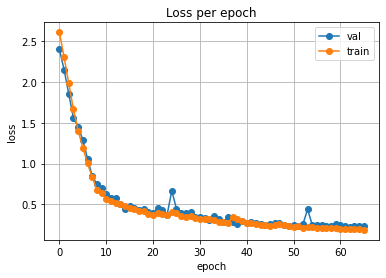

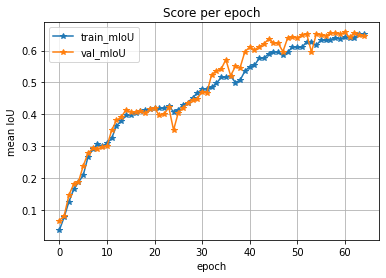

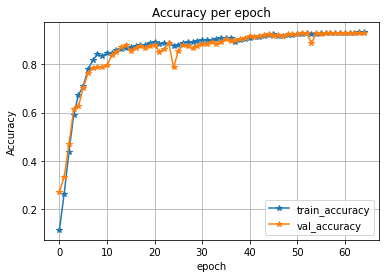

In [54]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [55]:
# load best saved checkpoint
model = torch.load('Unet-efficientb4_qiita.pt')

In [56]:
class testDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        #t = T.Compose([T.ToTensor()])
        #image = t(image)
        mask = torch.from_numpy(mask).long()
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [57]:
# create test dataset
test_dataset = testDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [58]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [59]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [60]:
image, mask = test_dataset[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [61]:
image, mask = test_dataset[3]
image.shape

(384, 480, 3)

In [62]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [63]:
mob_miou = miou_score(model, test_dataset)
print('Test Set mIoU', np.mean(mob_miou))


Test Set mIoU 0.5616161760032894


In [64]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [65]:
mob_acc = pixel_acc(model, test_dataset)
print('Test Set Pixel Accuracy', np.mean(mob_acc))


Test Set Pixel Accuracy 0.8789779437514903


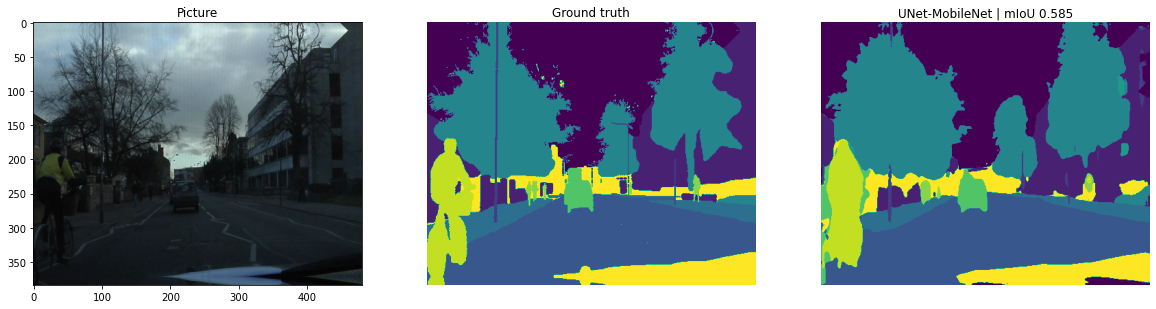

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

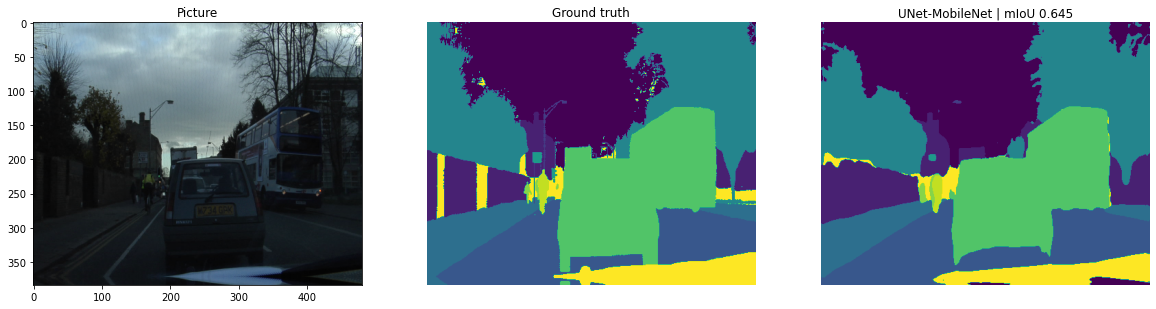

In [67]:
image2, mask2 = test_dataset[15]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [68]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

UNet-EfficientNet-B4 | mIoU 0.599


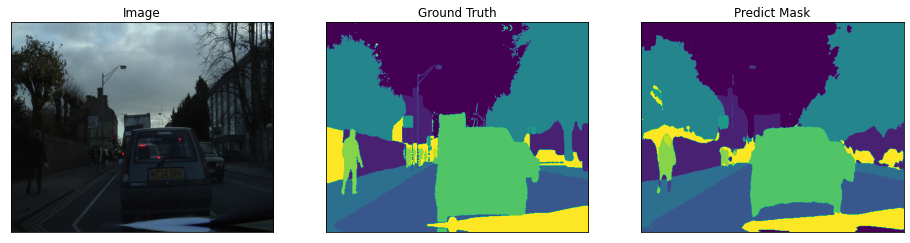

UNet-EfficientNet-B4 | mIoU 0.528


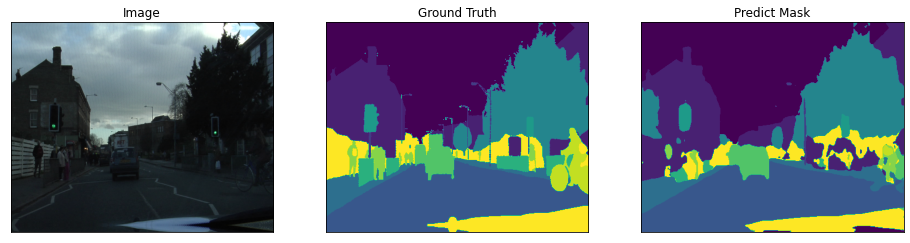

UNet-EfficientNet-B4 | mIoU 0.522


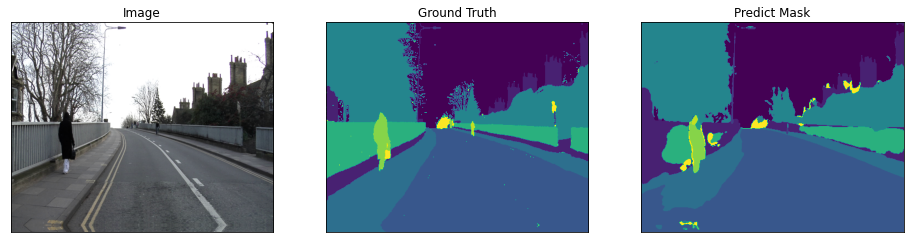

UNet-EfficientNet-B4 | mIoU 0.557


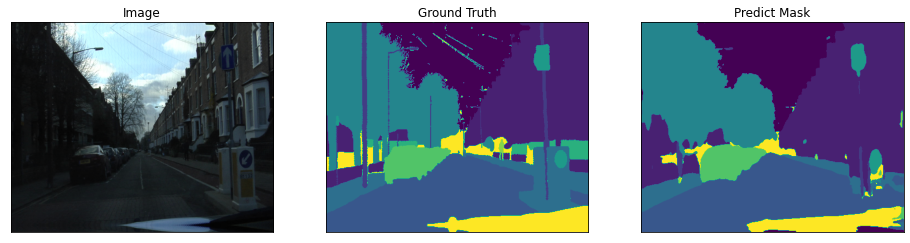

In [69]:
for i in range(4):
    n = np.random.choice(len(test_dataset))
    
    image2, mask2 = test_dataset[n]
    
    pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)
    
    print('UNet-EfficientNet-B4 | mIoU {:.3f}'.format(score2))
    
    visualize(
        image=image2, 
        ground_truth=mask2,
        predict_mask = pred_mask2,
    )